# 1.  U-Net trained on the MoNuSeg data set
This notebook is for training a model on the data from the MonSeg challenge. The goal is to train a model that will be used to find cell instances in the data from the SweBCH91RT study.

In [1]:
import random
import json
from itertools import cycle
import xml.etree.ElementTree as ET
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from PIL import Image
from PIL import Image, ImageDraw
from skimage.draw import polygon
from skimage.io import imread, imshow
from skimage.transform import resize
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from keras.utils import Sequence
from keras.utils.np_utils import to_categorical   
from keras.models import Model, load_model
from keras.layers import Input, multiply
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
import pandas as pd
import tensorflow as tf
import wandb
from wandb.keras import WandbCallback

import utils
from weighted_loss_unet import make_weighted_loss_unet, my_loss

from augmented_sequence import AugmentedSequence

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
BATCH_SIZE = 5

## Setting up training, validation and test groups
Should use all MoNuSeg data, not only the test data

In [3]:
monuseg_patinfo = pd.read_csv(Path(os.getcwd()).parent / 'data/monuseg/patient_information.csv')

monuseg_train_ids = monuseg_patinfo[monuseg_patinfo['training'] == 'yes']['patient_id']
monuseg_test_ids = monuseg_patinfo[monuseg_patinfo['training'] == 'no']['patient_id']
monuseg_train_ids, monuseg_val_ids = monuseg_utils.val_split(monuseg_train_ids)

## Data augmentation

In [4]:
seq = iaa.Sequential([
    iaa.CropToFixedSize(width=round(IMG_WIDTH*1.5), height=round(IMG_HEIGHT*1.5)),
    iaa.flip.Flipud(p=0.5),
    iaa.flip.Fliplr(p=0.5),
    iaa.Affine(rotate=(-45,45)),
    iaa.CropToFixedSize(width=IMG_WIDTH, height=IMG_HEIGHT, position="center"),
    iaa.Sometimes(0.2, iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))),
    iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0.0, 3.0)))
    #iaa.Sometimes(0.2, iaa.EdgeDetect((0,0.5)))
])

val_sequential = iaa.Sequential([
    iaa.CropToFixedSize(width=round(IMG_WIDTH*1.5), height=round(IMG_HEIGHT*1.5)),
    iaa.flip.Flipud(p=0.5),
    iaa.flip.Fliplr(p=0.5),
    iaa.Affine(rotate=(-45,45)),
    iaa.CropToFixedSize(width=IMG_WIDTH, height=IMG_HEIGHT, position="center"),
])

train_seq = AugmentedSequence(monuseg_train_ids, BATCH_SIZE, seq, IMG_WIDTH, IMG_HEIGHT)
val_seq = AugmentedSequence(monuseg_val_ids, BATCH_SIZE, val_sequential, IMG_WIDTH, IMG_HEIGHT)

## Sanity check

Text(0.5, 1.0, 'Mask')

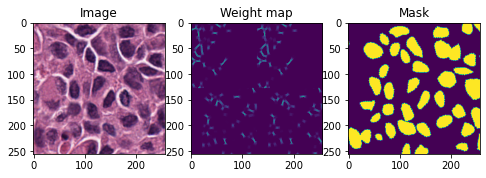

In [5]:
(img_b, wmap_b), mask_b = train_seq[0]
img = img_b[0]
wmap = wmap_b[2,:,:,1]
mask = mask_b[0,:,:,1]
plt.figure(figsize=(8,8))
plt.subplot(131)
plt.imshow(img)
plt.title("Image")
plt.subplot(132)
plt.imshow(wmap)
plt.title("Weight map")
plt.subplot(133)
plt.imshow(mask)
plt.title("Mask")
# ## Train U-Net
# The U-Net, along with the weight map loss function, was implemented by [jaidevd](https://jaidevd.github.io/posts/weighted-loss-functions-for-instance-segmentation/).

In [6]:
def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection) / (union)
    return (1-jac)

In [7]:
#tf.compat.v1.disable_eager_execution()
name = 'unet_model'
if f"{name}.h5" in os.listdir('./models/'):
    print("Loading existing model...", end='')
    model = keras.models.load_model(f'./models/{name}.h5',
                        custom_objects={'my_loss' : my_loss, 'iou': iou})
    print("Done!")
else:
    wandb.init(project="swebcg91rt-net")
    model = make_weighted_loss_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), 2, is_training = True)
    model.compile(optimizer='adam', loss=my_loss, metrics=[iou])
    model.fit(train_seq, validation_data=val_seq, epochs=300, callbacks=[WandbCallback()]) 

    # Save model to wandb
    model.save(os.path.join(wandb.run.dir, "model.h5"))
    model.save(f'./models(unet_model_{time()}.h5')
    

# Post-processing
We use some of the techniques found in the [NucleAIzer Paper](https://www.sciencedirect.com/science/article/pii/S2405471220301174).
1. Remove small objects entierly within larger objects.
2. Objects smaller than p1 pixels are removed.
3. Descide on optimal threshold, p2.

In [8]:
# Our inference model won't take a weight map as an input.
model_inference = make_weighted_loss_unet((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), 2, False)
model_inference.set_weights(model.get_weights())

In [9]:
import skimage.morphology as morphology
from scipy.optimize import minimize

def post_processing(prediction, p):
    prediction = (prediction > p[0])
    prediction = morphology.area_closing(prediction, area_threshold=p[1])
    prediction = morphology.remove_small_holes(prediction, area_threshold=p[2])
    prediction = morphology.remove_small_objects(prediction, min_size=p[3])
    return prediction

def make_sequence(patient_ids):
    """ Making a regular sequence without any augmentations. """
    crop_seq = iaa.Sequential([iaa.CropToFixedSize(width=IMG_WIDTH, height=IMG_HEIGHT)])
    return AugmentedSequence(patient_ids, BATCH_SIZE, crop_seq, IMG_WIDTH, IMG_HEIGHT)

def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union

def mean_iou(y_true: list, y_pred : list):
    return np.mean([iou(yt, yp) for yt, yp in zip(y_true, y_pred)])

img_batches, y_true_batches = zip(*[(img_b, mask_b) for (img_b, _), mask_b in val_seq])
y_pred_batches = [model_inference.predict(img_b) for img_b in img_batches]

y_true = [y[...,1] for batch in y_true_batches for y in batch ]
y_pred = [y[...,1] for batch in y_pred_batches for y in batch ]

def loss(p):
    return - mean_iou(y_true, [post_processing(y, p) for y in y_pred])

p_optimal = minimize(loss, (0.7, 64, 64, 64), method='Nelder-Mead', options={'disp':True})

Optimization terminated successfully.
         Current function value: -0.598979
         Iterations: 71
         Function evaluations: 173


[ 0.23183877 71.17267317 78.35997174 67.6229343 ]


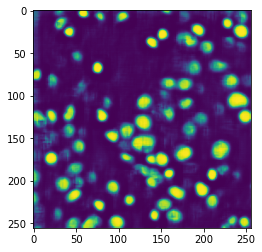

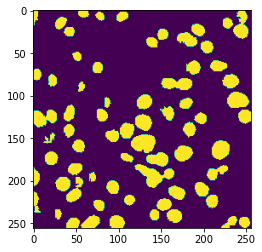

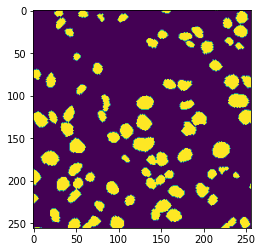

In [10]:
p = p_optimal["x"]
print(p)
n=1
plt.figure()
plt.imshow(y_pred[n])
plt.figure()
plt.imshow(post_processing(y_pred[n], p))
plt.figure()
plt.imshow(y_true[n])

In [11]:
def display_result(model, aug_sequence, threshold=0.5, batch_limit=1):
    for n, ((img_b, _), mask_b) in enumerate(aug_sequence):
        if n > batch_limit:
            break
        prediction = model.predict(img_b)
        for img, mask, pred in zip(img_b, mask_b, prediction):
            y_true = mask[:,:,1]
            plt.figure(figsize=(8,8))
            plt.subplot(141)
            plt.imshow(img)
            plt.title("Image")
        
            plt.subplot(142)
            plt.imshow(y_true)
            plt.title("Ground Truth")

            plt.subplot(143)
            plt.imshow(pred[:,:,1])
            plt.title("Predicted")
            
            plt.subplot(144)
            rounded = np.array((pred[:,:,1] > threshold), dtype=np.float32)
            intersection = np.logical_and(y_true, rounded).sum()
            union = np.logical_or(y_true, rounded).sum()
            iou = round(intersection / union, 2)
            plt.imshow(rounded)
            plt.title(f"IoU: {iou}")

## Predict on test set

In [12]:
val_seq = make_sequence(monuseg_val_ids)

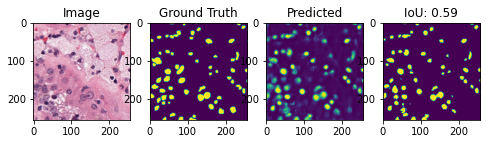

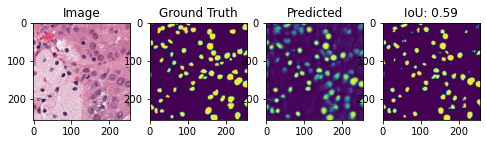

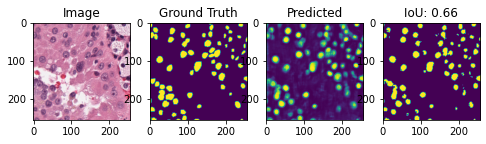

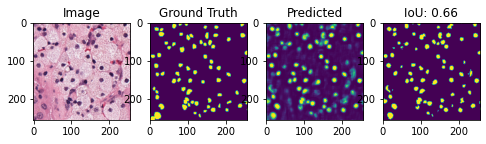

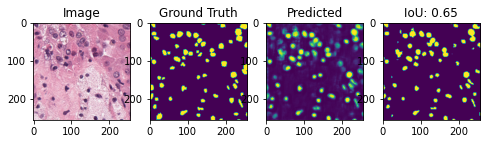

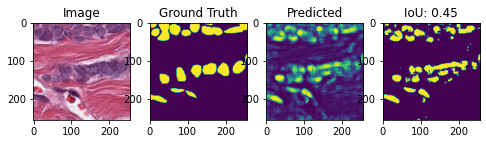

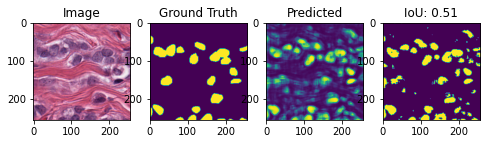

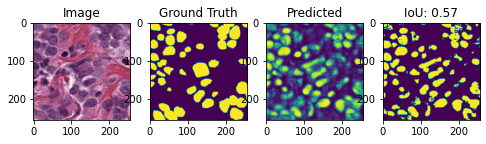

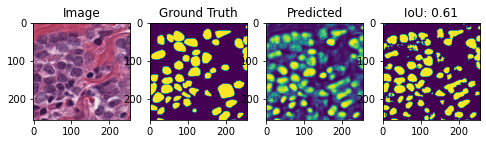

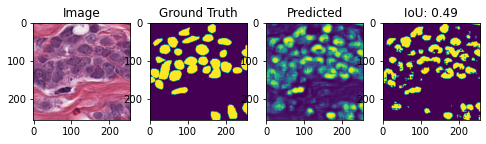

In [13]:
def display_result(model, test_sequence, threshold=0.5, batch_limit=1):
    for n, ((img_b, _), mask_b) in enumerate(test_sequence):
        if n > batch_limit:
            break
        prediction = model.predict(img_b)
        for img, mask, pred in zip(img_b, mask_b, prediction):
            y_true = mask[:,:,1]
            plt.figure(figsize=(8,8))
            plt.subplot(141)
            plt.imshow(img)
            plt.title("Image")
        
            plt.subplot(142)
            plt.imshow(y_true)
            plt.title("Ground Truth")

            plt.subplot(143)
            plt.imshow(pred[:,:,1])
            plt.title("Predicted")
            
            plt.subplot(144)
            rounded = np.array((pred[:,:,1] > threshold), dtype=np.float32)
            intersection = np.logical_and(y_true, rounded).sum()
            union = np.logical_or(y_true, rounded).sum()
            iou = round(intersection / union, 2)
            plt.imshow(rounded)
            plt.title(f"IoU: {iou}")

display_result(model_inference, val_seq, 0.5)
